# NeedleNet and error correction for microneedle project
by [Yang Liu](https://liuyang12.github.io), [MIT CSAIL](https://csail.mit.edu). Last updated Sep 30, 2021 

## NeedleNet as the vision system

In [1]:
# import external packages
import csv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from reedmuller import reedmuller  # Reed-Muller code

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# import internal packages
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from predict import (load_needlenet, microneedle_array_from_raw_image)

In [2]:
# needle_size = 10 # side of the microneedle array 10x10 or 12x12
needle_size = 12 # side of the microneedle array 10x10 or 12x12

# num_training = 100 # number of training samples *1k
num_training = 150 # number of training samples *1k

known_patt_info = True # known pattern information from the filename '_PatternXX_'
patt_str = '_Pattern'  # substring in the filename

model  = f'../checkpoints/model_{needle_size}x{needle_size}_{num_training}k.pth'

# load pre-trained NeedleNet [only once]
needlenet = load_needlenet(model)

In [3]:
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/10x10 Pattern/Applicator 3/Day 16 - 07.22.21/TF_Pattern6_Con/LI.L.TF..22JULY2021_6.jpg"

# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/12x12 Pattern/12 x12_400um_1mm_App3/Day 8 -08.31.2021/Rum_L_BR_Pattern13/Rum.L.BR.Aug31.2021_24.jpg"
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/12x12 Pattern/12 x12_400um_1mm_App3/Day 23 - 09.15.2021/Rum_L_BR_Pattern13/Rum.L.BR.sept15.21_10.jpg"
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/12x12 Pattern/12 x12_400um_1mm_App3/Day 8 -08.31.2021/Rum_L_TF_Pattern11/Rum.L.TF.Aug31.2021_29.jpg"
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/Dara-Azarenka/Pattern/Dara_Patterned_Dec9/Dara.right.3A.Dec9.2021_8.jpg"

imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/12x12 Pattern/12 x12_400um_1mm_App3/Day 38 - 09.30.2021/Rum_L_BR_Pattern13/Rum.L.BR.sept30.2021_6.jpg"
# predict binary microneedle array from the raw input image
im = cv.imread(imfile, 0)
needle, im_crop = microneedle_array_from_raw_image(im, needle_size, net=needlenet)

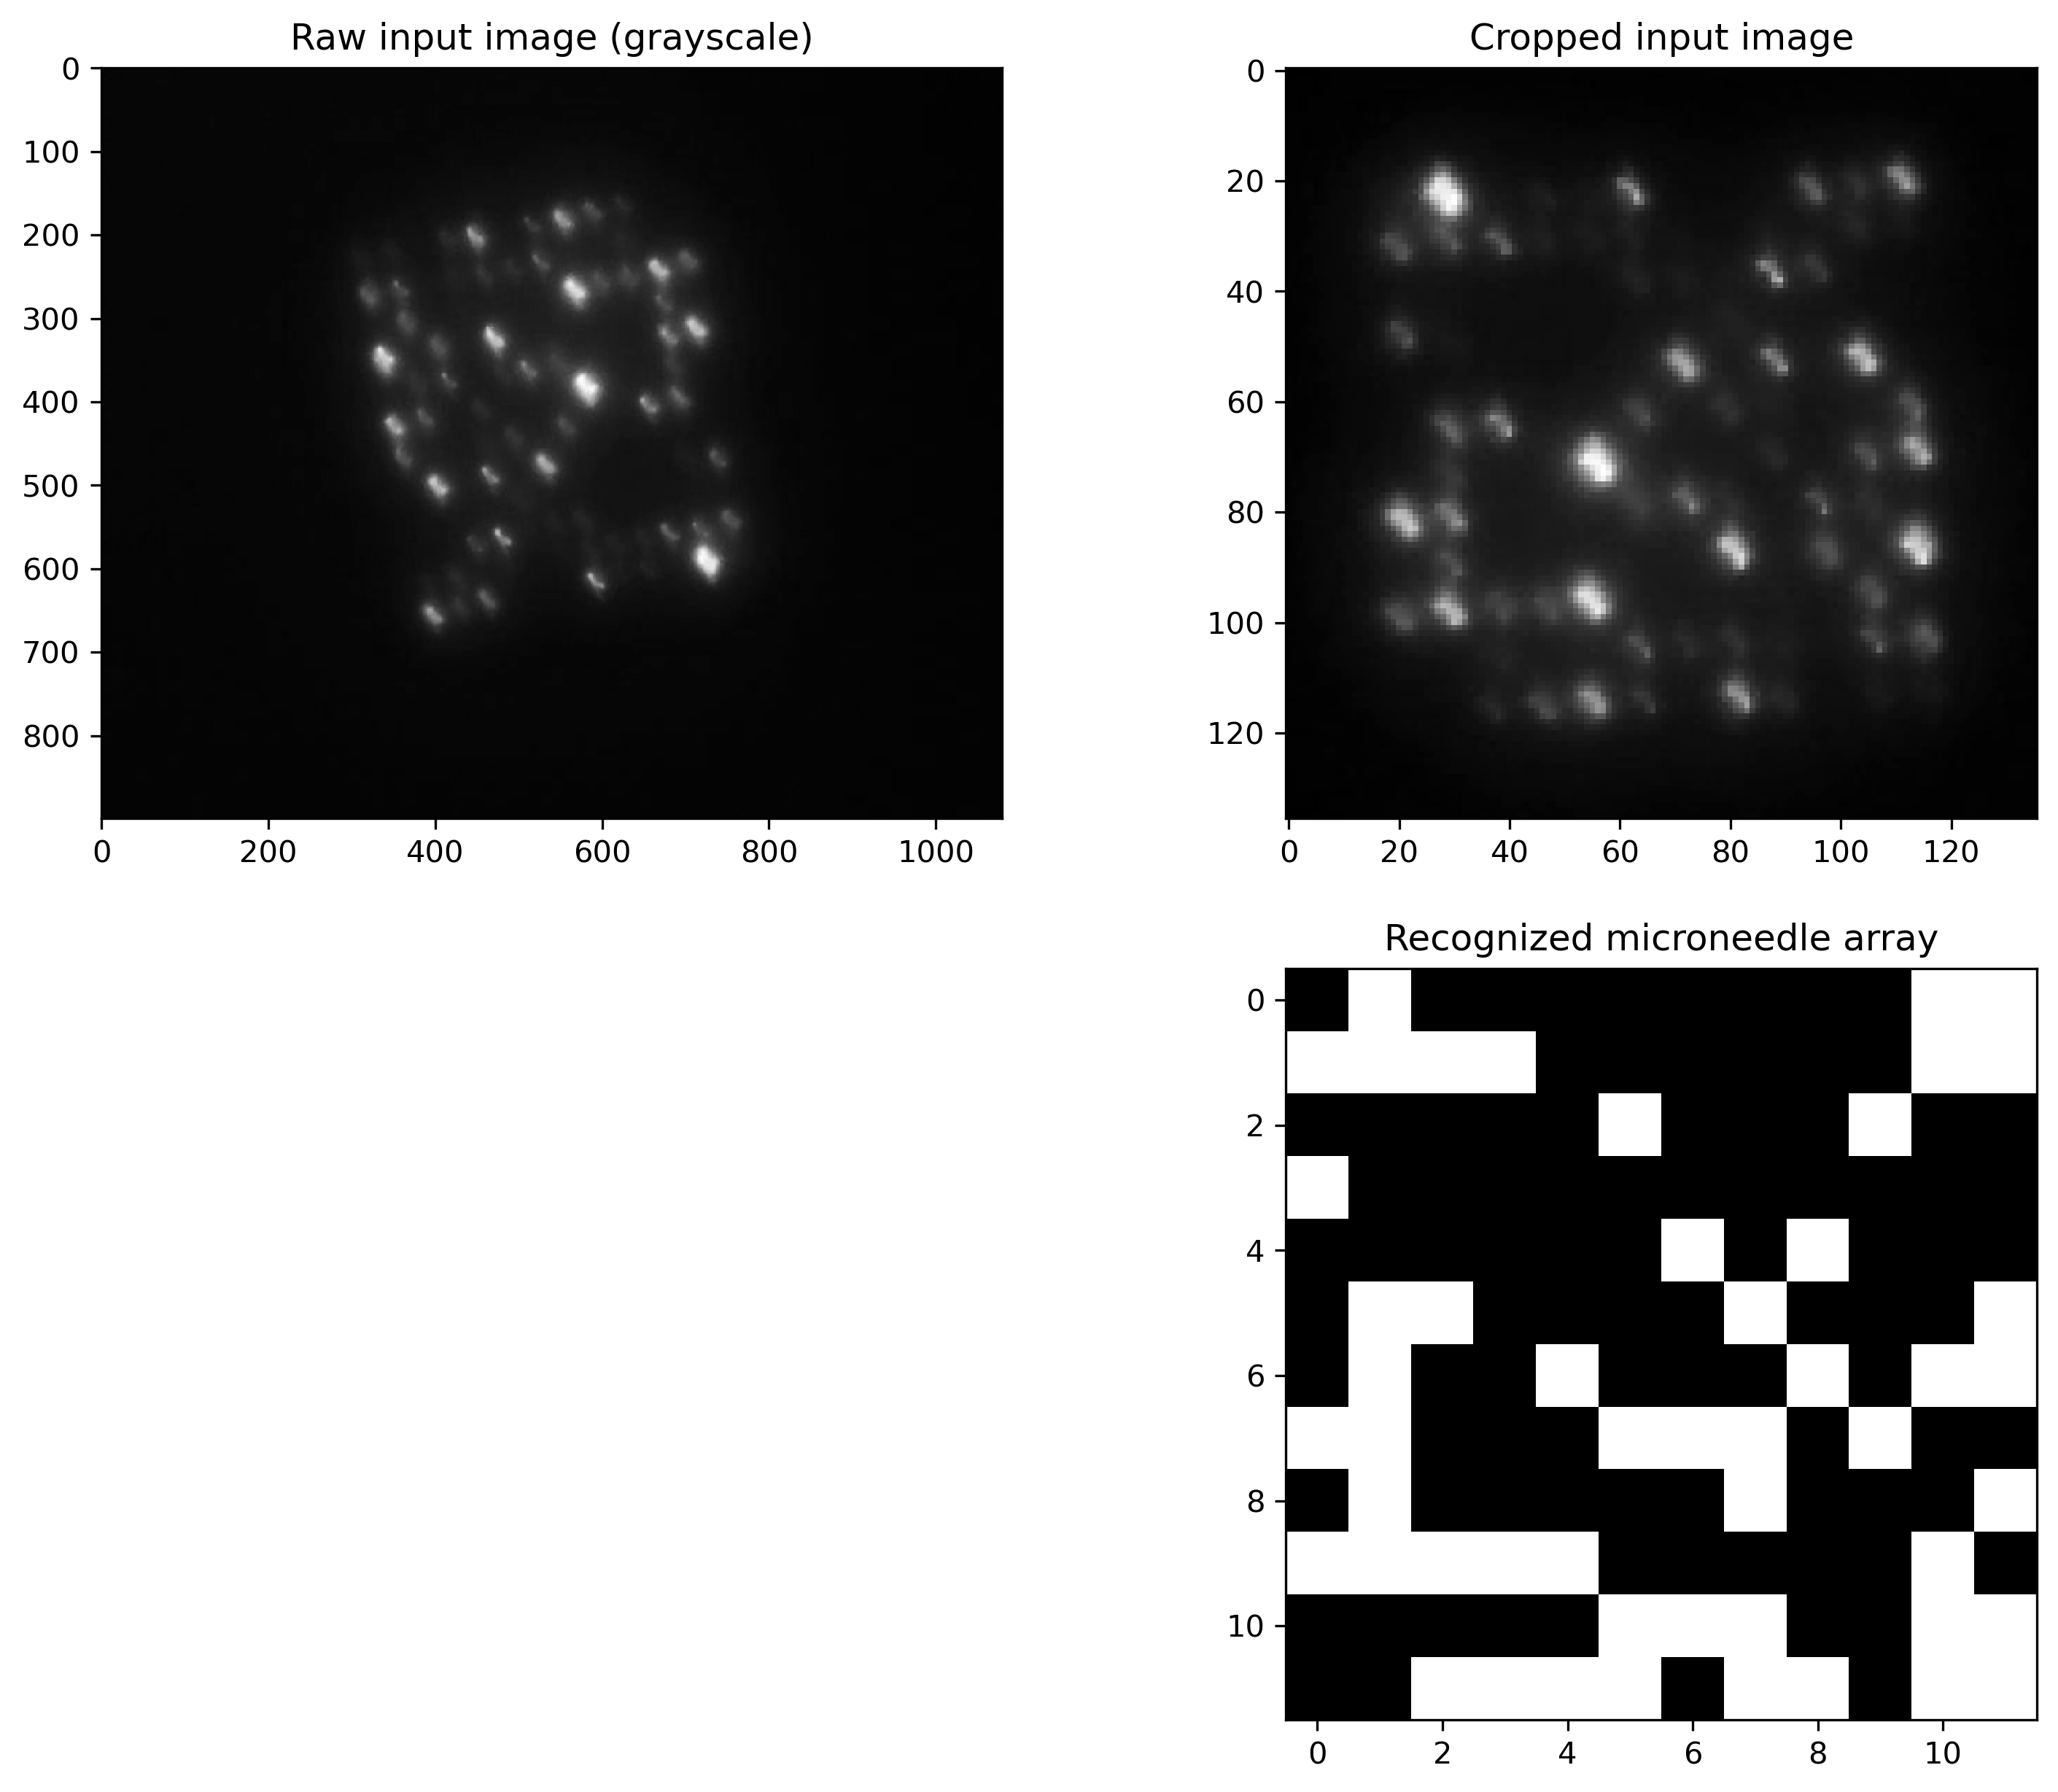

In [4]:
plt.figure(figsize=(12,10),dpi=300)
plt.subplot(221)
plt.imshow(im, cmap='gray')
plt.title('Raw input image (grayscale)')
plt.subplot(222)
plt.imshow(im_crop, cmap='gray')
plt.title('Cropped input image')
plt.subplot(224)
plt.imshow(needle, cmap='gray')
plt.title('Recognized microneedle array')
plt.show()

## Error-correction decoding and calculate the bit error rate (BER) according to decoded pattern
Note that we use the four corners for orientation detection and then get the right orientation of the pattern and finally include four corners in the bir error rate (BER) as well.

In [5]:
# [0] layout of the microneedle array
#     only use 64 bits for encoding RM(1,8) or [64,7,32]_2-code
if needle_size == 10:
    corner_size = 3
    corner_hole = True
    rm_order = 1
    use_mask = False
elif needle_size == 12:
    corner_size = 2
    corner_hole = False
    rm_order = 2
    use_mask = True
else:
    corner_size = 2
    corner_hole = False
    rm_order = 1
    use_mask = False

s = needle_size   # side of the microneedle array - s x s
p = corner_size   # preserved 4 corners for orientation (p x p top-right)

# [0.1] show a blank microneedle array with a template
blank = np.zeros((s,s), dtype=bool) # blank array with all zeros (binary 0/1 )
blank[0:p,0:p] = 1;   # top-left
blank[-p:,0:p] = 1;   # bottom-left
blank[0:p,-p:] = 1;   # top-right
blank[-p:,-p:] = 0;   # bottom-right 

if corner_hole:
    blank[ p//2, p//2] = 0;
    blank[-p//2, p//2] = 0;
    blank[ p//2,-p//2] = 0;

# [2] Reed-Muller encoder
totalbits = s*s - 4*p*p   # total number of bits for encoding

# [2.1] RM(r,m) code
r = rm_order                      # order of RM(r,m) code 
m = int(np.log2(totalbits))    # exponent of RM(r,m) code
rmcode = reedmuller.ReedMuller(r,m) # Reed-Muller RM(r,m) code
# first-order RM(1,m) code -- [n,k,d] or [2^m, m+1, 2^(m-r)]_2-code with 2^(m-r-1)-1 maximum error correction bits
n = rmcode.block_length()   # block length 2^m
k = rmcode.message_length() # message length m+1 (first-order)
ec = rmcode.strength()      # number of correctable error bits 2^(m-r-1)-1

print('            Bits used for encoding:  %2d bits' % n)
print('                      Message bits:  %2d bits' % k)
print('Maximum number of correctable bits:  %2d bits' % ec)

# [3.1] get the indices for encoding locations
idxmat  = np.arange(s*s).reshape(s,s) # all indices for each bit
idxmat[0:p,0:p] = -1   # top-left
idxmat[-p:,0:p] = -1   # bottom-left
idxmat[0:p,-p:] = -1   # top-right
idxmat[-p:,-p:] = -1   # bottom-right 
idxvec = idxmat[idxmat > 0]

            Bits used for encoding:  128 bits
                      Message bits:  29 bits
Maximum number of correctable bits:  15 bits


In [6]:
# load mask if using a mask for encoding
if use_mask:
    import scipy.io as sio
    maskfile = f'../checkpoints/mask_{needle_size}x{needle_size}.mat'
    if os.path.isfile(maskfile):
        data = sio.loadmat(maskfile)
        mask = data['mask']
        print(f'loaded mask file {maskfile}')
    else:
        # add a random bianry mask
        mask = np.random.randint(2, size=(s,s))
        mask[0:p,0:p] = 0;   # top-left
        mask[-p:,0:p] = 0;   # bottom-left
        mask[0:p,-p:] = 0;   # top-right
        mask[-p:,-p:] = 0;   # bottom-right 
        sio.savemat(maskfile,{'mask':mask})
        print(f'regenerated and saved mask file {maskfile}')

loaded mask file ../checkpoints/mask_12x12.mat


In [7]:
# flip the binary 
# noisyneedle = needle
noisyneedle = np.flip(needle,1).astype(int)

c1 = np.sum(noisyneedle[0:p,0:p])   # top-left
c2 = np.sum(noisyneedle[0:p,-p:])   # top-right
c3 = np.sum(noisyneedle[-p:,-p:])
c4 = np.sum(noisyneedle[-p:,0:p])   # bottom-left

rotnum = np.argmin([c1,c2,c3,c4]) + 2

noisyneedle = np.rot90(noisyneedle,rotnum)

In [8]:
# [2.2] translate the text message (vaccine type and date ) to binary bits
if needle_size == 10:
    # message length k = 7
    nbits = [1,2,4] # number of bits for each block
                  # [1-bit] type 1-2 (start from 1)
                  # [2-bit] year 1-4 (start from 1)
                  # [4-bit] month 1-12 (start from 1)
elif needle_size == 12:
    nbits = [4,4,14,3,4] # number of bits for each block
                  # [4-bit] type 1-16 (start from 1)
                  # [4-bit] manufacturer 1-16 (start from 1)
                  # [14-bit] LOT/batch 1-16384 (start from 1)
                  # [3-bit] year 1-8 (start from 1)
                  # [4-bit] month 1-12 (start from 1)
else:
    print('Specify number of bits for each block')

noisyneedle_mask = noisyneedle
if use_mask:
    noisyneedle = np.logical_xor(noisyneedle, mask)
    
noisycode = np.zeros(n)
for i in range(n):
    noisycode[i] = noisyneedle[idxvec[i]//s,idxvec[i]%s]

# [5] run Reed-Muller error correction decoding to get the formated message
y = rmcode.decode(noisycode)

if y is None:
    print('  Reed-Muller decoding failed.')
else:
    space = ''
    print('  Binary corrected bits:  %s' % space.join(map(str, y)))

    cumbits = np.cumsum(nbits)
    cumbits = np.append([0], cumbits)
    vinfo_dec = np.zeros([len(nbits), 1])
    text_dec = ''
    # decoded vaccine types and dates
    for ibit in range(len(nbits)):
        vinfo_dec[ibit] = int(space.join(
            map(str, y[cumbits[ibit]:cumbits[ibit+1]])), 2) + 1
        text_dec = text_dec + '%02d-' % vinfo_dec[ibit]

    text_dec = text_dec[:-1]
    print('  Decoded info: Vaccine %s' % (text_dec))

  Reed-Muller decoding failed.


In [9]:
# get ground truth pattern information from filename '_PatternXX_'
success = True
patt_info = 'NA'
if known_patt_info:
    # load the pattern information csv file as a dictionary for queries
    with open('../checkpoints/pattern_info.csv', mode='r') as csvfile:
        reader = csv.reader(csvfile)
        patt_info_dict = {rows[0]: rows[1] for rows in reader}

    digit_idx = imfile.find(patt_str)
    if digit_idx > 0:
        if imfile[digit_idx+len(patt_str)+1].isdigit():
            patt_num = imfile[digit_idx+len(patt_str):digit_idx+len(patt_str)+2]
        else:
            patt_num = imfile[digit_idx+len(patt_str)]

        patt_info = patt_info_dict[patt_num]

        info = list(map(int, patt_info.split('-')))

        v = []
        for ibit in range(len(nbits)):
            binfo = list(map(int, '{0:0b}'.format(info[ibit]-1)))
            v = v + [0]*(nbits[ibit]-len(binfo)) + binfo

        success = (v == y)
    else:
        known_patt_info = False

  Number of error pixels: 25
  Bit error rate: 17.36%
  Number of info error pixels (excluding four 12x12 corners): 24
  Error correction failed.


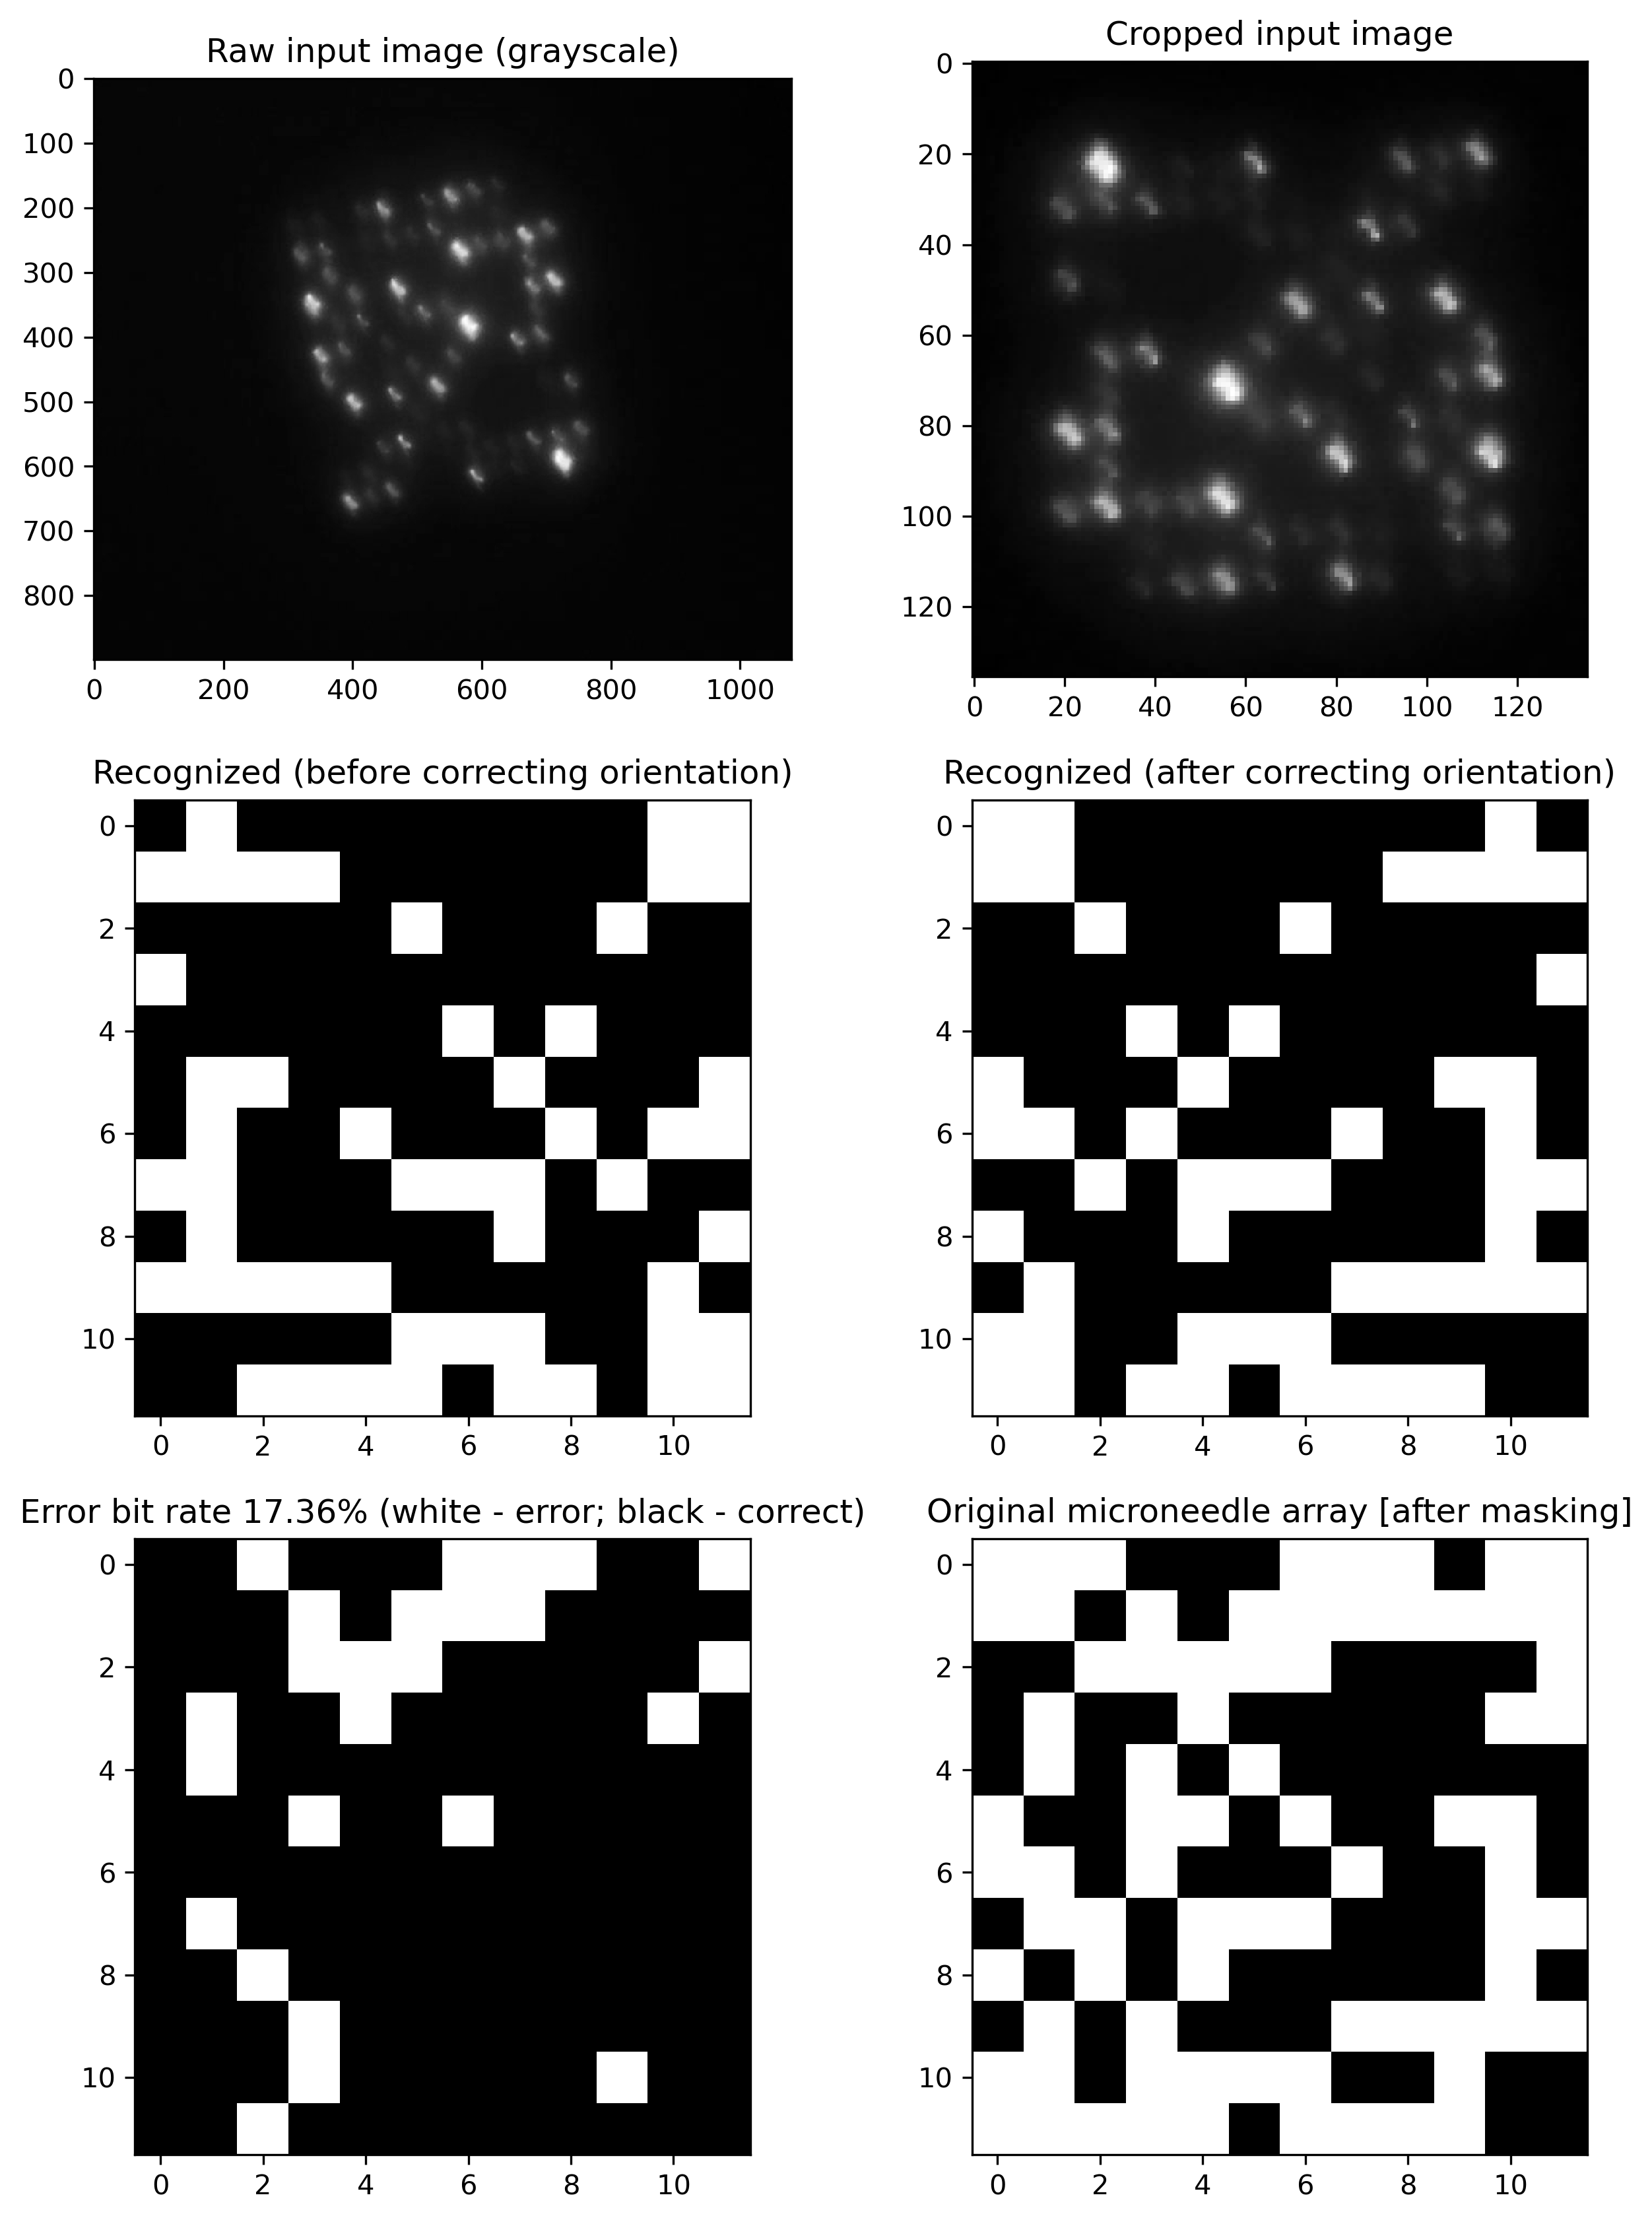

In [10]:
# [3.2] assign value to each bit in the microneedle
origneedle = blank.copy()

infomat = np.ones((s,s), dtype=bool) # blank array with all zeros (binary 0/1 )
infomat[0:p,0:p] = 0;   # top-left
infomat[-p:,0:p] = 0;   # bottom-left
infomat[0:p,-p:] = 0;   # top-right
infomat[-p:,-p:] = 0;   # bottom-right

# needle[idxvec] = code
if known_patt_info:
    origcode = rmcode.encode(v)
else:
    origcode = rmcode.encode(y)
for i in range(n):
    origneedle[idxvec[i]//s,idxvec[i]%s] = origcode[i]

origneedle_bk = origneedle
if use_mask:
    origneedle = np.logical_xor(origneedle, mask).astype(int)
    
errorneedle = noisyneedle_mask-origneedle.astype(int)

num_error_bits = np.count_nonzero(errorneedle) # number of flipped pixel bits
num_info_error_bits = np.count_nonzero(errorneedle*infomat) # number of flipped pixel bits

ber = num_error_bits/(s*s) # bit error rate
if not known_patt_info:
    success = (num_info_error_bits <= ec) # 

print('  Number of error pixels: %d' % num_error_bits)
print('  Bit error rate: {:.2%}'.format(ber))
print('  Number of info error pixels (excluding four %dx%d corners): %d' % (s,s,num_info_error_bits))
if success:
    print('  Successful error correction!')
else:
    print('  Error correction failed.')

plt.figure(figsize=(10,14),dpi=300)
plt.subplot(321)
plt.imshow(im, cmap='gray')
plt.title('Raw input image (grayscale)')
plt.subplot(322)
plt.imshow(im_crop, cmap='gray')
plt.title('Cropped input image')
plt.subplot(323)
plt.imshow(needle, cmap='gray')
plt.title('Recognized (before correcting orientation)')
plt.subplot(324)
plt.imshow(noisyneedle_mask, cmap='gray')
plt.title('Recognized (after correcting orientation)')
plt.subplot(326)
plt.imshow(origneedle, cmap='gray')
plt.title('Original microneedle array [after masking]')
plt.subplot(325)
plt.imshow(np.absolute(errorneedle), cmap='gray')
plt.title('Error bit rate {:.2%} (white - error; black - correct)'.format(ber))
plt.show()

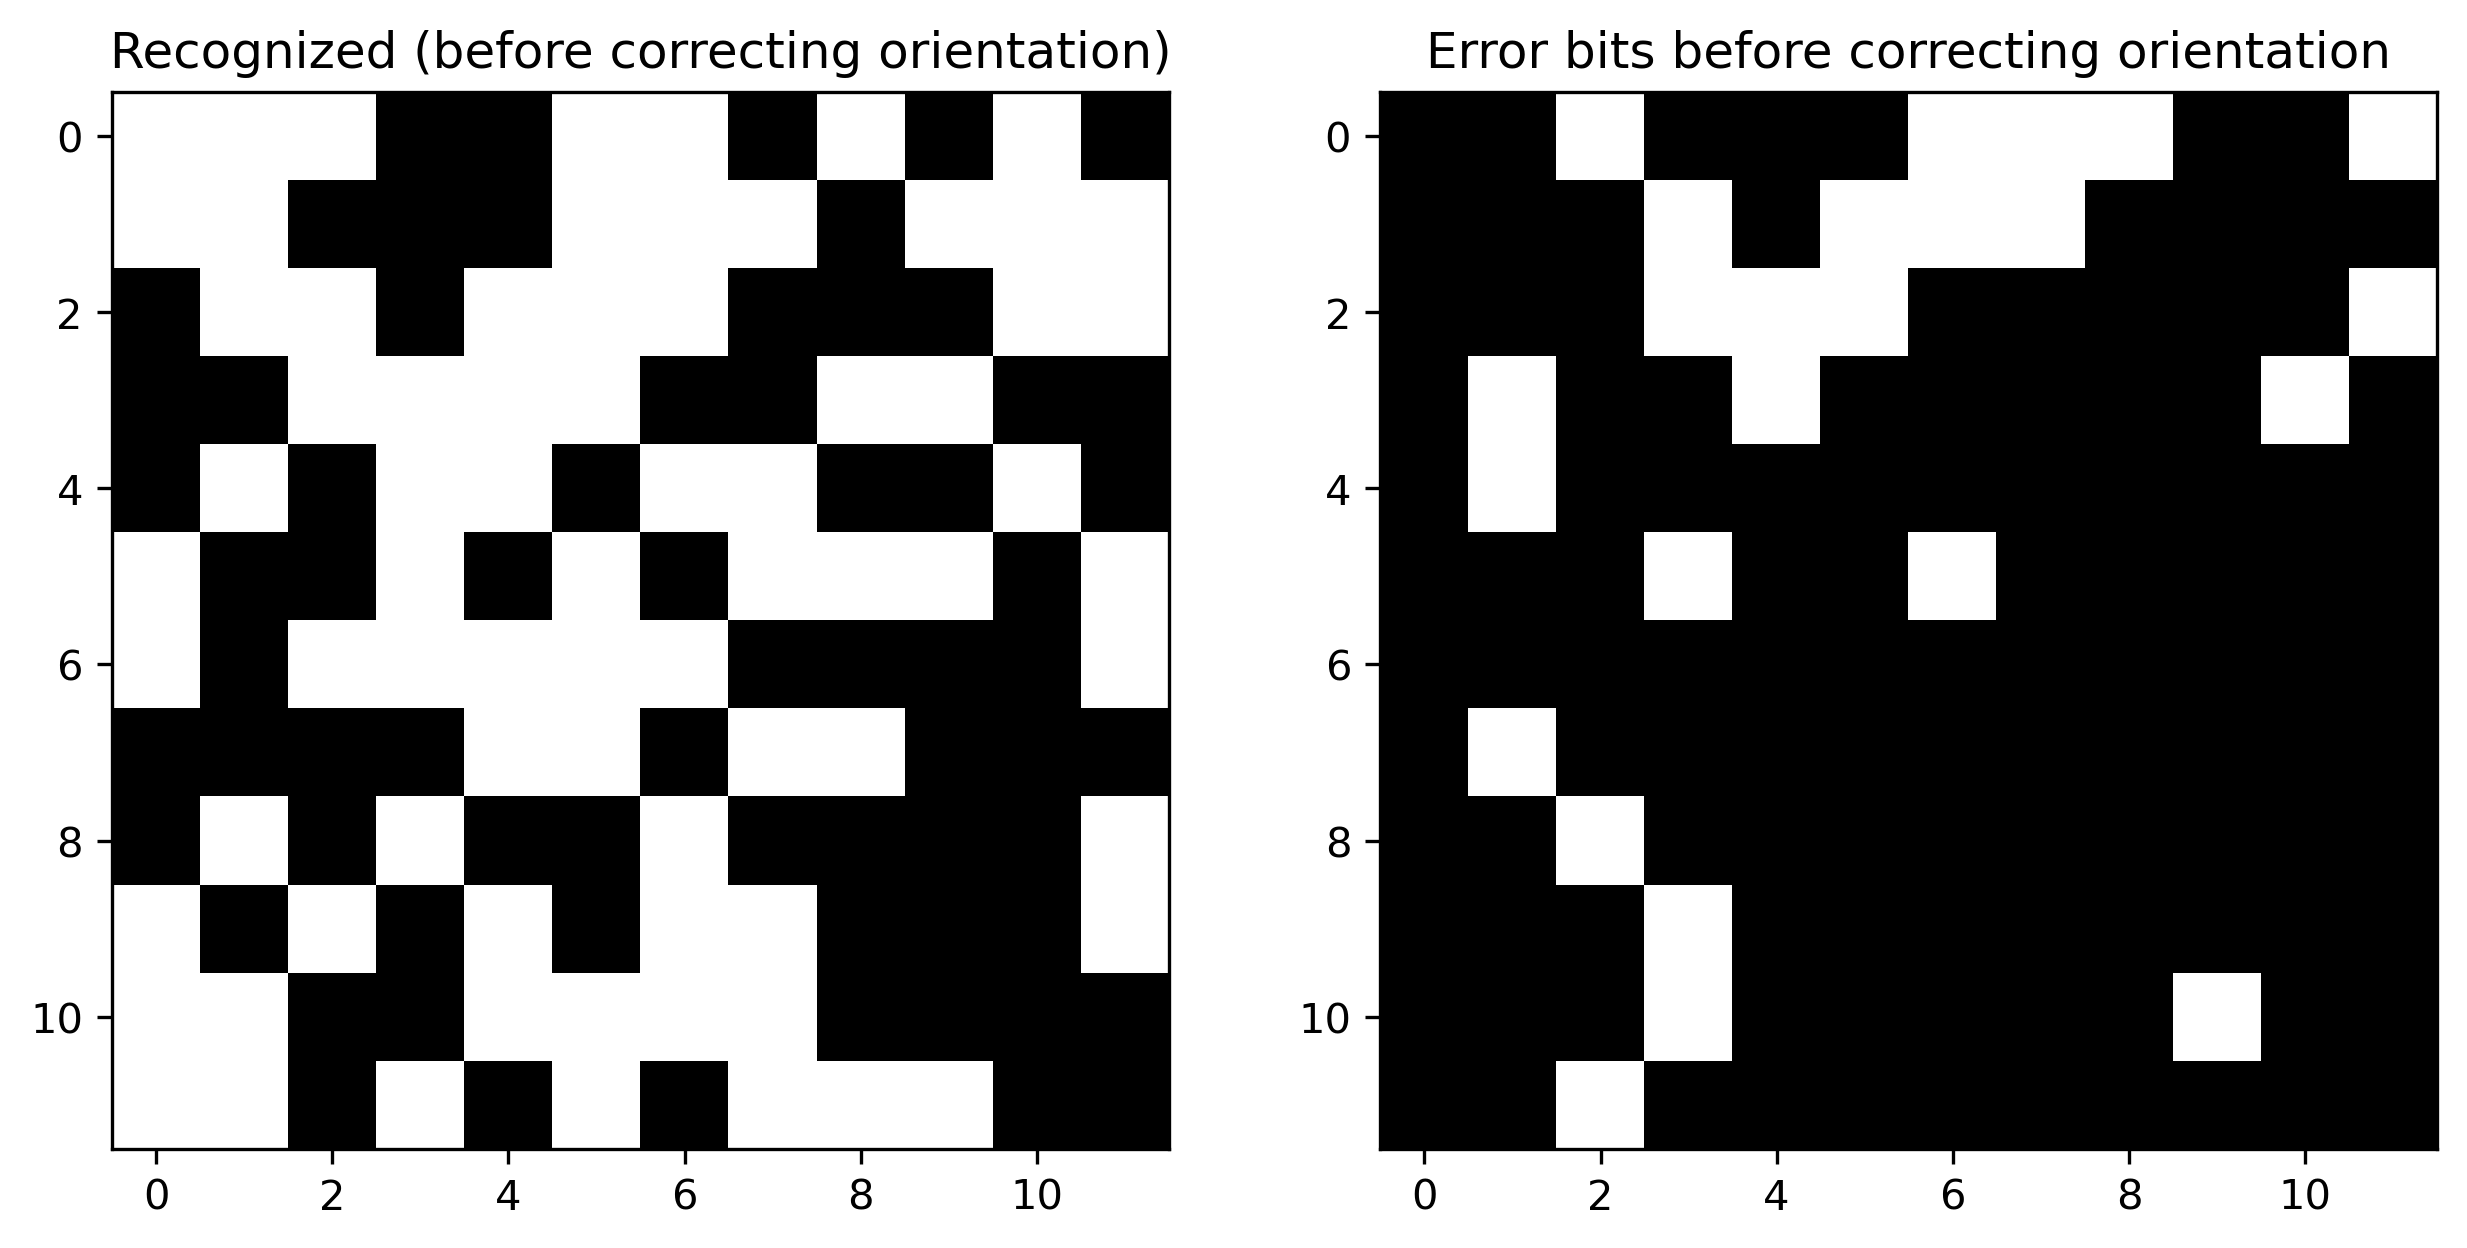

In [11]:
plt.figure(figsize=(10,14),dpi=300)
plt.subplot(121)
plt.imshow(noisyneedle, cmap='gray')
plt.title('Recognized (before correcting orientation)')
plt.subplot(122)
plt.imshow(np.absolute(noisyneedle-origneedle_bk.astype(int)), cmap='gray')
plt.title('Error bits before correcting orientation')
plt.show()